In [1]:
import sys
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
import os

sys.path.append("../../src")
from common import config
from data.initializer import DataLoaderSaver
from collections import defaultdict
from tqdm.notebook import tqdm

%load_ext autoreload

In [2]:
DATASET_NAME = "jobs_published"

paths = config.Paths(
    dataset_name=DATASET_NAME,
    target_users_name="all",
)

In [3]:
%%time
from data.initializer import DataLoaderSaver

data = DataLoaderSaver()

data.load_interactions(paths.interactions)

interactions = data.interactions
interactions

CPU times: user 1min 7s, sys: 16.3 s, total: 1min 23s
Wall time: 1min 30s


,user,item,event,timestamp
0,27901,56865,click,1581465600
1,124480,115662,click,1581465600
2,159509,5150,click,1581465600
3,188861,109981,click,1581465600
4,207348,88746,click,1581465600
...,...,...,...,...
65502196,2876233,90074,click,1582675199
65502197,3011254,90671,click,1582675199
65502198,3011612,62471,click,1582675199
65502199,3045719,27937,click,1582675199


In [4]:
def groupby_to_list(df, key1, key2, column):
    d = defaultdict(list)
    for k1, k2, value in tqdm(zip(df[key1], df[key2], df[column])):
        d[(k1, k2)].append(value)
    return pd.DataFrame([(k[0], k[1], v, len(v)) for k, v in d.items()], columns=[key1, key2, column, 'multiplicity'])

interactions_unique = groupby_to_list(interactions, 'user', 'item', 'event')
interactions_unique = interactions_unique.rename(columns={"event": 'events'})
interactions_unique

0it [00:00, ?it/s]

,user,item,events,multiplicity
0,27901,56865,[click],1
1,124480,115662,[click],1
2,159509,5150,"[click, contact_phone_click_1, contact_phone_c...",3
3,188861,109981,"[click, click]",2
4,207348,88746,[click],1
...,...,...,...,...
47167309,2876233,90074,[click],1
47167310,3011254,90671,[click],1
47167311,3011612,62471,[click],1
47167312,3045719,27937,[click],1


# Basics statistics of the dataset

In [5]:
n_users = interactions["user"].nunique()
n_items = interactions["item"].nunique()
n_interactions = len(interactions)
n_interactions_unique = len(interactions_unique)

interactions_per_user = interactions.groupby("user").size()
interactions_unique_per_user = interactions_unique.groupby("user").size()
interactions_per_item = interactions.groupby("item").size()
interactions_unique_per_item = interactions_unique.groupby("item").size()

print(f"We have:\
      \n{n_users} users,\
      \n{n_items} items,\
      \n{n_interactions} interactions,\
      \n{n_interactions_unique} unique (user, item) pairs with interactions.\n")

print(
    f"Data sparsity (% of missing entries) is {round(100 * (1- n_interactions_unique / (n_users * n_items)), 4)}%.\n"
)

print(
    f"Average number of interactions per user is {round(interactions_per_user.mean(), 3)}\
    (standard deviation {round(interactions_per_user.std(ddof=0),3)}).\n"
)

print(
    f"Average number of unique interactions per user is {round(interactions_unique_per_user.mean(), 3)}\
    (standard deviation {round(interactions_unique_per_user.std(ddof=0),3)}).\n"
)

print(
    f"Average number of interactions per item is {round(interactions_per_item.mean(), 3)}\
    (standard deviation {round(interactions_per_item.std(ddof=0),3)}).\n"
)

print(
    f"Average number of unique interactions per item is {round(interactions_unique_per_item.mean(), 3)}\
    (standard deviation {round(interactions_unique_per_item.std(ddof=0),3)}).\n"
)

We have:      
3295942 users,      
185395 items,      
65502201 interactions,      
47167314 unique (user, item) pairs with interactions.

Data sparsity (% of missing entries) is 99.9923%.

Average number of interactions per user is 19.874    (standard deviation 47.762).

Average number of unique interactions per user is 14.311    (standard deviation 29.231).

Average number of interactions per item is 353.312    (standard deviation 624.773).

Average number of unique interactions per item is 254.415    (standard deviation 426.019).



# Interactions distribution per user

In [6]:
def compute_quantiles(series, quantiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]):
    return pd.DataFrame(
        [[quantile, series.quantile(quantile)] for quantile in quantiles],
        columns=["quantile", "value"],
    )


print("Interactions distribution per user:")
display(compute_quantiles(interactions_per_user))

print("Unique interactions distribution per user:")
compute_quantiles(interactions_unique_per_user)

Interactions distribution per user:


,quantile,value
0,0.01,1.0
1,0.10,1.0
2,0.25,2.0
3,0.50,6.0
4,0.75,18.0
5,0.90,46.0
6,0.99,221.0


Unique interactions distribution per user:


,quantile,value
0,0.01,1.0
1,0.10,1.0
2,0.25,2.0
3,0.50,5.0
4,0.75,14.0
5,0.90,34.0
6,0.99,140.0


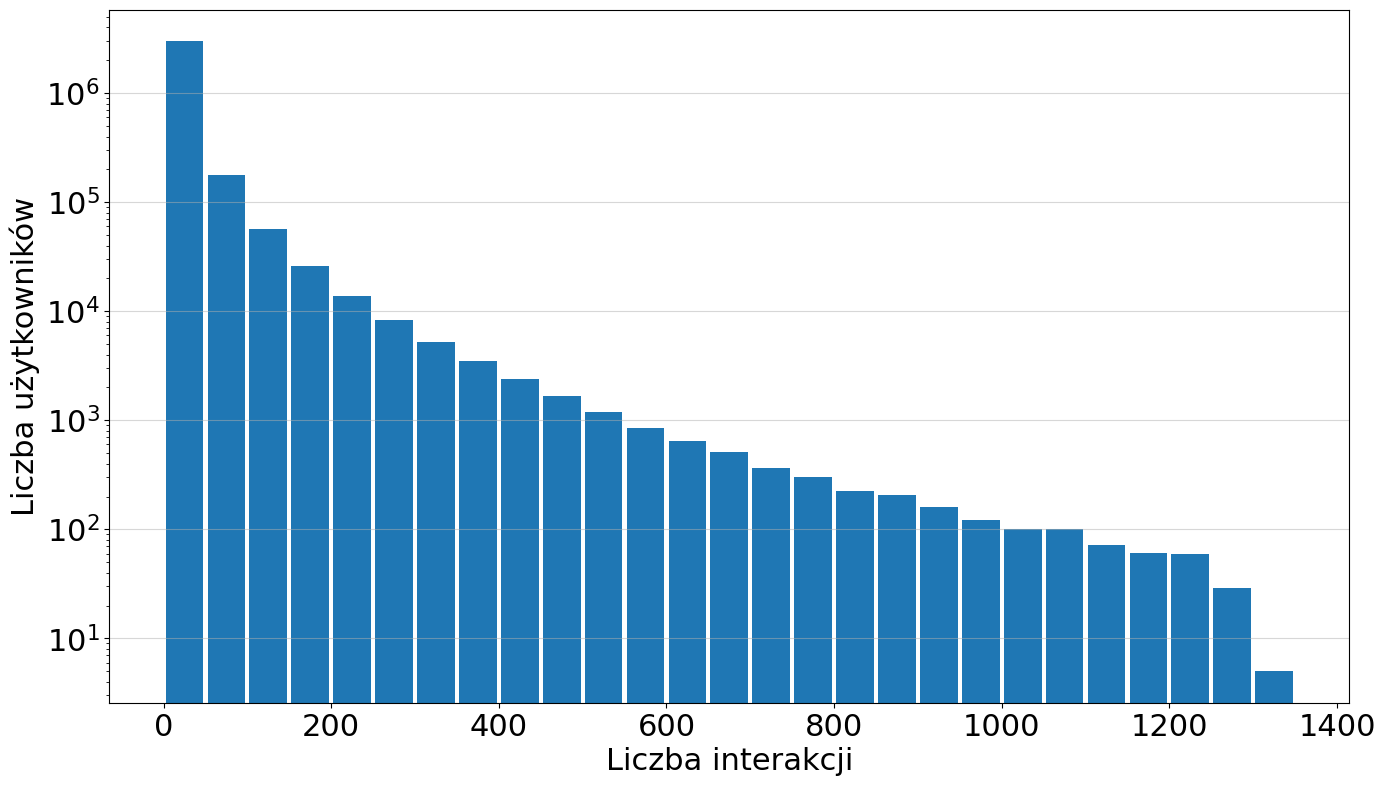

In [7]:
def plot_interactions_distribution(series, aggregation="user", ylabel="Users", is_unique=False, bin_size=50, logy=True, save_suffix='', language='pl'):
    matplotlib.rcParams.update({"font.size": 22})
    series.plot.hist(bins=range(0, max(series)+1+bin_size, bin_size), rwidth=0.9, logy=logy, figsize=(16, 9))
    if language=='en':
        plt.title(f"Number of {'unique ' if is_unique else ''}interactions per {aggregation}")
        plt.xlabel("Interactions")
        plt.ylabel(ylabel)
    elif language=='pl':
        pl_aggregation = 'użytkowników' if aggregation=='user' else 'przedmiotów'
        # plt.title(f"Liczba {'unikalnych ' if is_unique else ''}interakcji {pl_aggregation}")
        plt.xlabel(f"Liczba {'unikalnych ' if is_unique else ''}interakcji")
        plt.ylabel(f"Liczba {pl_aggregation}")

    plt.grid(axis="y", alpha=0.5)

    images_dir = f"images/{DATASET_NAME}"
    if not os.path.isdir(images_dir):
        os.makedirs(images_dir)
    plt.savefig(f"images/{DATASET_NAME}/{'unique_' if is_unique else ''}interactions_per_{aggregation}_{language}{save_suffix}.pdf", format="pdf")


plot_interactions_distribution(interactions_per_user, "user", "Users", bin_size=50)

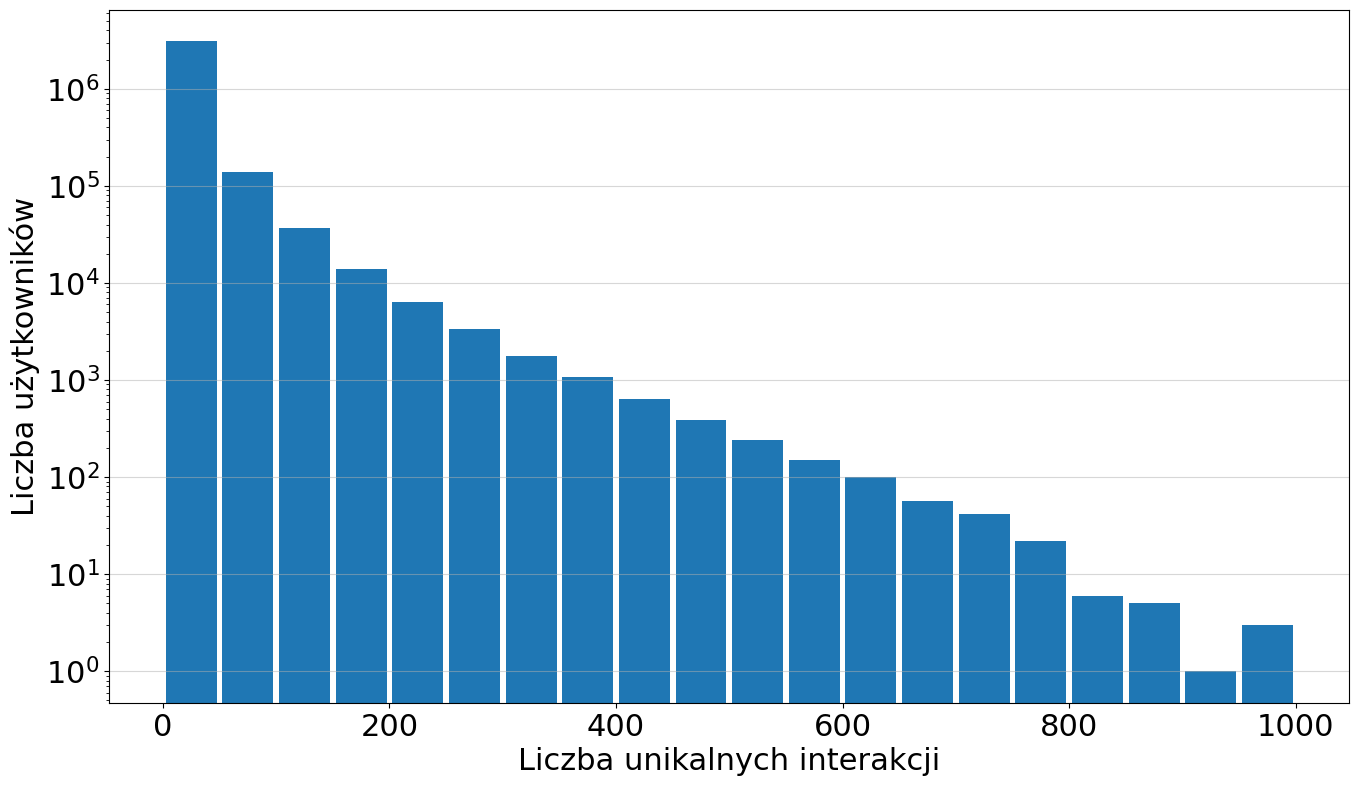

In [8]:
plot_interactions_distribution(interactions_unique_per_user, "user", "Users", is_unique=True, bin_size=50)

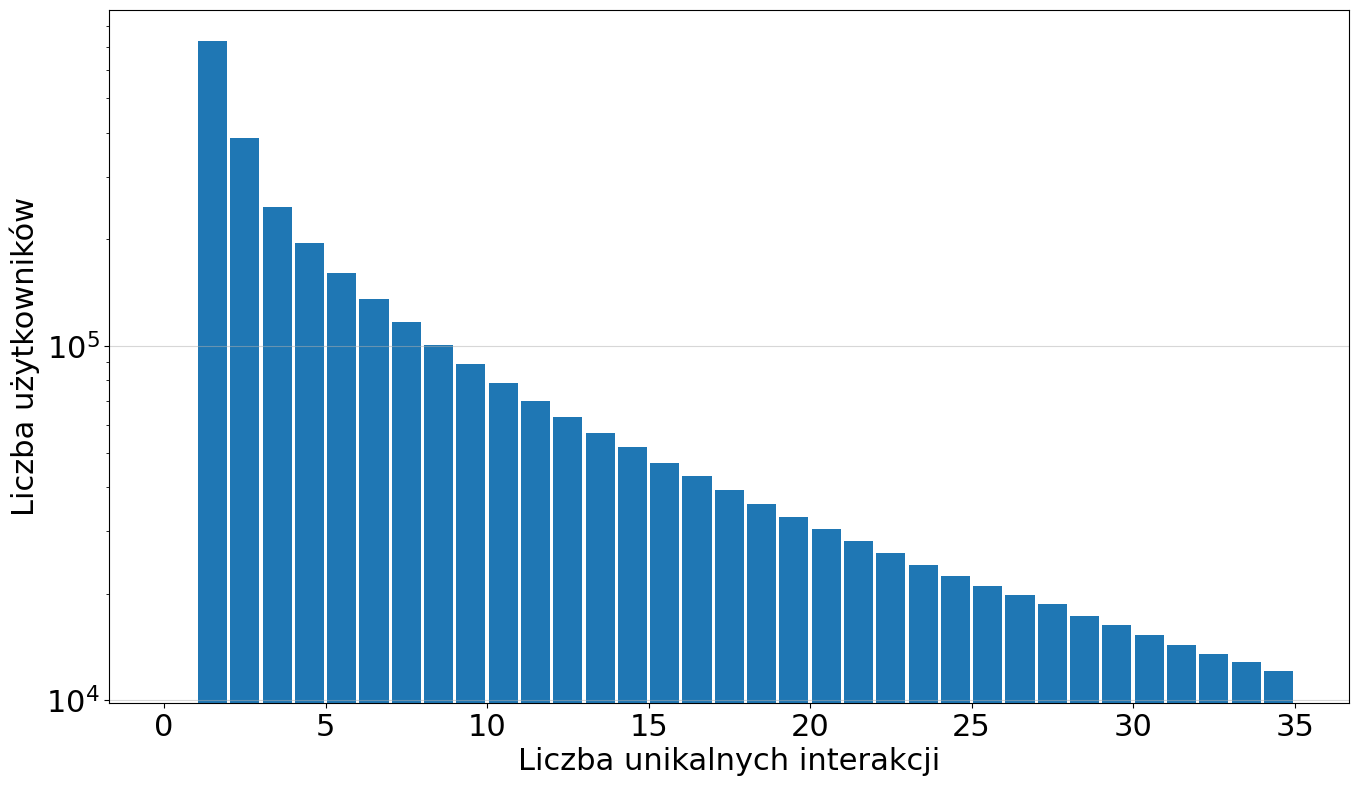

In [9]:
interactions_unique_per_user_truncated = interactions_unique_per_user[interactions_unique_per_user<=34]

plot_interactions_distribution(interactions_unique_per_user_truncated, "user", "Users", is_unique=True, bin_size=1, logy=True, save_suffix='_top34')

# Interactions distribution per item

In [10]:
print("Interactions distribution per item:")
display(compute_quantiles(interactions_per_item))

print("Unique interactions distribution per item:")
display(compute_quantiles(interactions_unique_per_item))

Interactions distribution per item:


,quantile,value
0,0.01,1.00
1,0.10,1.00
2,0.25,3.00
3,0.50,137.00
4,0.75,428.00
5,0.90,950.00
6,0.99,2944.06


Unique interactions distribution per item:


,quantile,value
0,0.01,1.0
1,0.10,1.0
2,0.25,3.0
3,0.50,105.0
4,0.75,319.0
5,0.90,683.0
6,0.99,1993.0


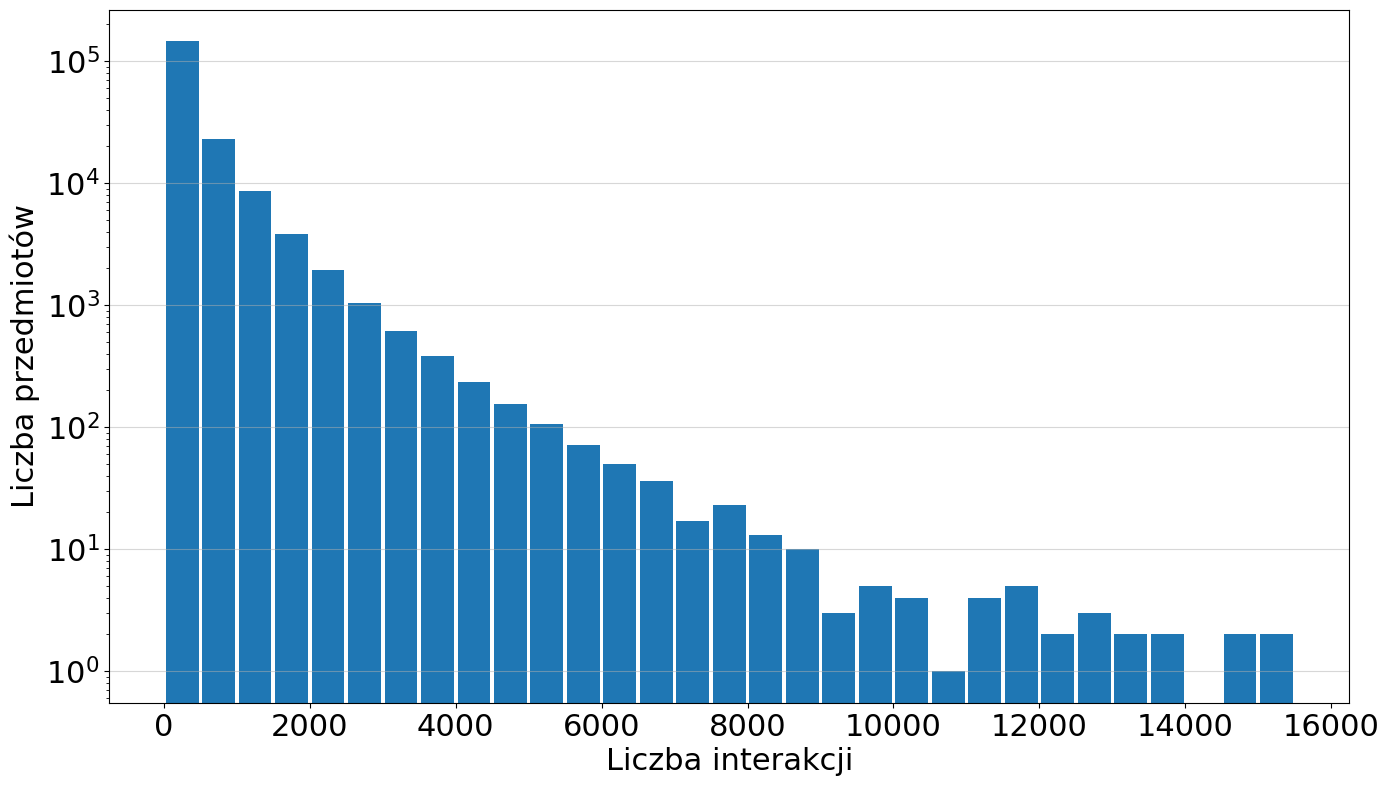

In [11]:
plot_interactions_distribution(interactions_per_item, "item", "Items", bin_size=500)

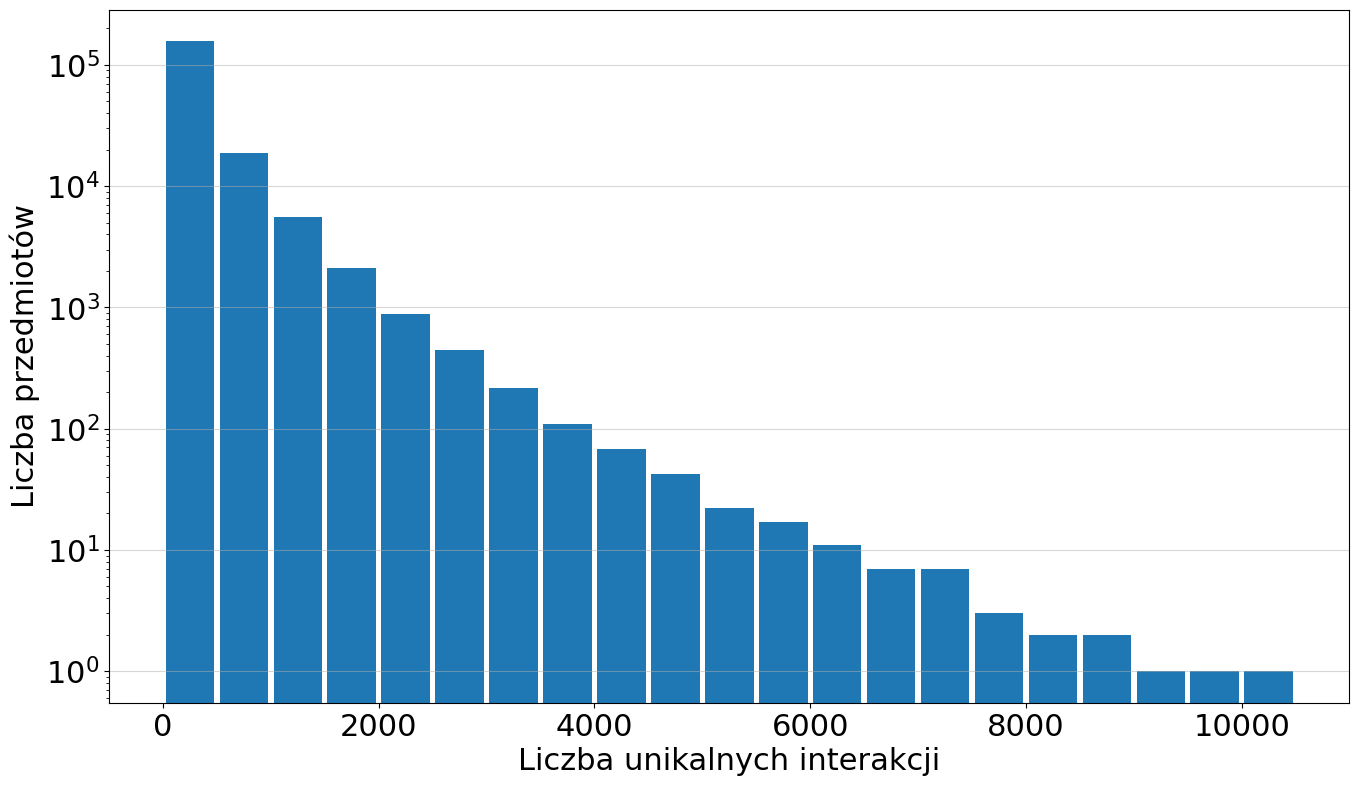

In [12]:
plot_interactions_distribution(interactions_unique_per_item, "item", "Items", bin_size=500, is_unique=True)

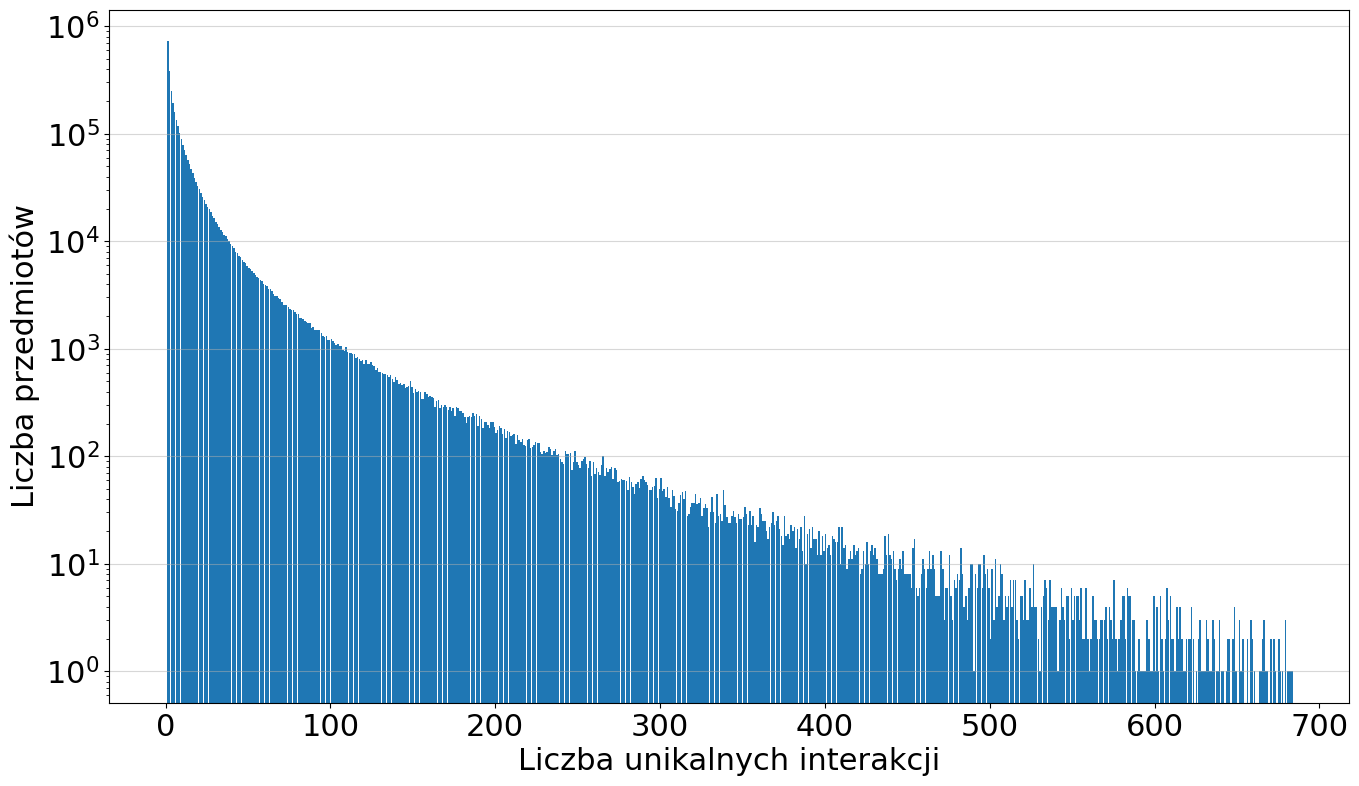

In [13]:
interactions_unique_per_item_truncated = interactions_unique_per_user[interactions_unique_per_user<=683]

plot_interactions_distribution(interactions_unique_per_item_truncated, "item", "Items", is_unique=True, bin_size=1, logy=True, save_suffix='_top683')

Item popularity per interaction

In [14]:
popularity_per_interaction = pd.merge(interactions, 
        pd.DataFrame(interactions_unique_per_item).reset_index().rename(columns={0: "popularity"}),
        on='item')

In [15]:
popularity_per_interaction_quantiles = compute_quantiles(popularity_per_interaction["popularity"], quantiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])
popularity_per_interaction_quantiles

,quantile,value
0,0.01,46.0
1,0.10,178.0
2,0.25,346.0
3,0.50,688.0
4,0.75,1286.0
5,0.90,2167.0
6,0.99,5121.0


In [16]:
# calculate what % of most popular items covers 50% of interactions
popularity_threshold = popularity_per_interaction_quantiles.query("quantile == 0.50")["value"].item()
popular_items = interactions_unique_per_item[interactions_unique_per_item>popularity_threshold]
len(popular_items)/len(interactions_unique_per_item)

0.09874592087165242

In [17]:
# calculate what % of users interacts only with these items
least_popular_item_per_user = popularity_per_interaction.groupby("user")["popularity"].min()
sum(least_popular_item_per_user>popularity_threshold)/len(least_popular_item_per_user)

0.13999851939142133

# Events distribution

In [18]:
event_frequency = pd.DataFrame(
    interactions["event"].value_counts() / len(interactions)
).rename(columns={"count": "frequency"})

event_frequency["frequency"] = event_frequency["frequency"].apply(
    lambda x: f"{round(100*x,3)}%"
)
event_frequency

,frequency
event,
click,89.794%
contact_phone_click_1,2.628%
bookmark,2.511%
chat_click,2.136%
contact_chat,1.448%
contact_partner_click,0.701%
contact_phone_click_2,0.679%
contact_phone_click_3,0.103%


In [19]:
# number of users with clicks only
users_with_not_only_clicks = interactions.query('event != "click"')["user"].nunique()
n_users = interactions["user"].nunique()
users_with_clicks_only = n_users - users_with_not_only_clicks
print(f'Users: {n_users}\n\
Users with clicks only: {users_with_clicks_only}\n\
Percent users with clicks only: {users_with_clicks_only/n_users}')

Users: 3295942
Users with clicks only: 2093777
Percent users with clicks only: 0.6352590549226897


# Multiple interactions for the same user-item pair

In [20]:
# fraction of multiple interactions our of all unique interactions
multiple_interactions = interactions_unique[interactions_unique["multiplicity"]>1]
len(multiple_interactions)/len(interactions_unique)

0.19124637879528184

In [21]:
# fraction of users with at least one multiple interaction
users_with_at_least_one_multiple_interaction = multiple_interactions[["user"]].drop_duplicates()
len(users_with_at_least_one_multiple_interaction)/interactions_unique["user"].nunique()

0.507096908865508

In [22]:
# what fraction of interactions are multiple for these users
interactions_unique_users_restricted = pd.merge(interactions_unique, users_with_at_least_one_multiple_interaction, on="user")
sum(interactions_unique_users_restricted["multiplicity"]>1)/len(interactions_unique_users_restricted)

0.22011833701540223

In [23]:
#distribution of multiple interactions
multiple_interactions["multiplicity"].value_counts(bins=[-1, 1, 2, 3, 4, 5, 6, 10, 10**10]).sort_index()/len(multiple_interactions)

multiplicity
(-1.001, 1.0]            0.000000
(1.0, 2.0]               0.585624
(2.0, 3.0]               0.199949
(3.0, 4.0]               0.089665
(4.0, 5.0]               0.045938
(5.0, 6.0]               0.026757
(6.0, 10.0]              0.038335
(10.0, 10000000000.0]    0.013731
Name: count, dtype: float64

In [24]:
multiple_interactions[["unique_events", "max_event"]] = multiple_interactions["events"].apply(lambda x: pd.Series([len(set(x)), max(x)]))

/var/folders/j1/15j8vtkx0pq48ts97f7fg9s4444p53/T/ipykernel_8603/3860357662.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multiple_interactions[["unique_events", "max_event"]] = multiple_interactions["events"].apply(lambda x: pd.Series([len(set(x)), max(x)]))
/var/folders/j1/15j8vtkx0pq48ts97f7fg9s4444p53/T/ipykernel_8603/3860357662.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multiple_interactions[["unique_events", "max_event"]] = multiple_interactions["events"].apply(lambda x: pd.Series([len(s

In [25]:
# calculate how many different types multiple interactions contains
print(multiple_interactions[multiple_interactions["unique_events"] == 1]["max_event"].value_counts()/len(multiple_interactions))
print(sum(multiple_interactions["unique_events"]>1)/len(multiple_interactions))

max_event
click                    6.102077e-01
bookmark                 5.532905e-04
contact_phone_click_1    3.069648e-04
contact_partner_click    1.506555e-04
contact_chat             3.447673e-05
chat_click               1.962180e-05
contact_phone_click_2    5.099451e-06
contact_phone_click_3    8.868611e-07
Name: count, dtype: float64
0.38872132140534676


# Interactions over time

In [26]:
def unix_to_day(timestamps):
    min_timestamp = timestamps.min()
    seconds_in_day = 60*60*24
    return (timestamps - min_timestamp)//seconds_in_day + 1


interactions["day"] = unix_to_day(interactions["timestamp"])

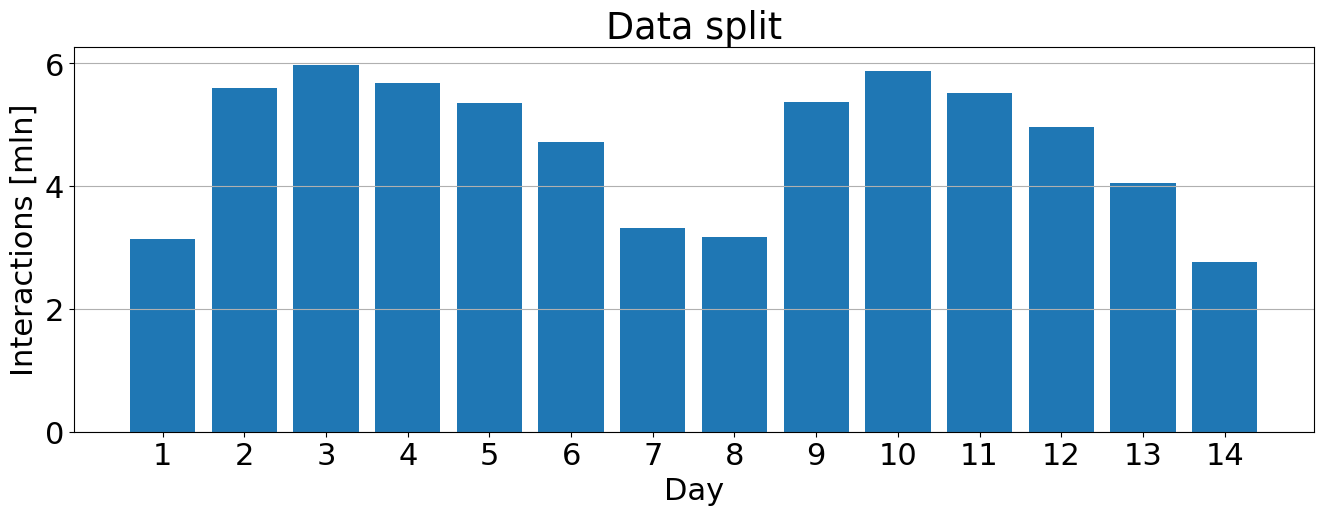

In [27]:
def plot_interactions_over_time(series):
    freq = series.value_counts()
    labels, counts = freq.index, freq.values/10**6
    
    matplotlib.rcParams.update({"font.size": 22})
    plt.figure(figsize=(16,5))
    plt.bar(labels, counts, align='center')
    plt.gca().set_xticks(labels)
    plt.title(f"Data split")
    plt.xlabel("Day")
    plt.ylabel("Interactions [mln]")
    plt.grid(axis="y")
    
plot_interactions_over_time(interactions["day"])